<a href="https://colab.research.google.com/github/yupopov/stepik-dl-cv/blob/main/module05_mnist_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification by LeNet

In this notebook we apply the classic LeNet network to the MNIST dataset classification and try to modify it in order to achieve better test prediction accuracy.

In [ ]:
import torch
import random
import numpy as np
from copy import deepcopy

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

len(y_train), len(y_test)

(60000, 10000)

Let's take a look at the objects in the dataset:

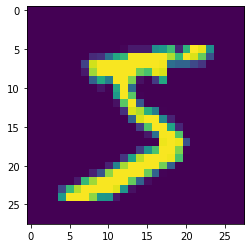

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Make each image a 1x28x28 tensor:

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

The LeNet architecture is as follows:

![](https://debuggercafe.com/wp-content/uploads/2019/07/Layers-in-LeNet.png)

Note that in the original MNIST dataset the images were 32x32, and we have 28x28 images. In order to preserve the layer structure, we add `padding=2` to the first convolution.

Moreover, we change the 5th layer for 5x5 convolution to flattening and applying the fully connected layer.

In [ ]:
def make_lenet(activation=torch.nn.Tanh(),
               pooling=torch.nn.AvgPool2d(kernel_size=2, stride=2)
               ):

    lenet_module_list = [
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        activation,
        pooling,
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        activation,
        pooling,
        torch.nn.Flatten(),
        torch.nn.Linear(5 * 5 * 16, 120),
        activation,
        torch.nn.Linear(120, 84),
        activation,
        torch.nn.Linear(84, 10)
    ]

    return torch.nn.Sequential(*lenet_module_list)

Our network has 61706 parameters (disregarding biases), most of them occupied by one fully connected layer.

In [ ]:
lenet5 = make_lenet()

print(f'Original LeNet has {sum(np.array(param.size()).prod() for param in lenet5.parameters())} parameters')
print('Parameters dimensions:')

for param in lenet5.parameters():
  print(np.array(param.size()))
del lenet5

Original LeNet has 61706 parameters
Parameters dimensions:
[6 1 5 5]
[6]
[16  6  5  5]
[16]
[120 400]
[120]
[ 84 120]
[84]
[10 84]
[10]


We put the whole dataset on GPU because it's not that large.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

Our main function for training networks is as follows:

In [ ]:
def train_network(network, batch_size=1024, n_epochs=100, optimizer=torch.optim.Adam, optimizer_params={}):

    network = network.to(device)
    # if network is None:
      # network = torch.nn.Sequential(*deepcopy(module_list))
      # make a deep copy of the list module
      # so that the network is initalized anew
      # each time we run the function
      # network = make_lenet(**lenet_params).to(device) 

    loss = torch.nn.CrossEntropyLoss()
    optimizer = optimizer(network.parameters(), **optimizer_params)

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []


    for epoch in range(n_epochs):
        order = np.random.permutation(len(X_train))
        # train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float)
        train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float).to(device)
        train_batch_loss_history = []
        
        network.train()
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size]
            
            # X_batch = X_train[batch_indexes].to(device) The whole MNIST dataset
            # y_batch = y_train[batch_indexes].to(device) fits on the GPU

            X_batch = X_train[batch_indexes] 
            y_batch = y_train[batch_indexes] 
            
            preds_batch = network.forward(X_batch) 
            
            loss_value = loss(preds_batch, y_batch)
            loss_value.backward()
            
            train_batch_loss_history.append(loss_value.tolist())

            # train_preds[batch_indexes] = preds_batch.cpu()
            train_preds[batch_indexes] = preds_batch #.cpu()

            optimizer.step()

        network.eval()
        with torch.no_grad():
            test_preds = network.forward(X_test)
            test_loss = loss(test_preds, y_test).cpu()
            test_loss_history.append(test_loss)
            
            test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
            test_accuracy_history.append(test_accuracy)

            train_loss = np.mean(train_batch_loss_history)
            train_loss_history.append(train_loss)
            
            train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().cpu()
            train_accuracy_history.append(train_accuracy)

    test_loss_history = np.array(test_loss_history)
    test_accuracy_history = np.array(test_accuracy_history)
    train_loss_history = np.array(train_loss_history)
    train_accuracy_history = np.array(train_accuracy_history)         

    return network, test_loss_history, test_accuracy_history, train_loss_history, train_accuracy_history

*How does adding different layers affect the learning rate (which layers are faster: convolutional or fully connected)?*

Recall that we have substituted a convolutional layer in the original LeNet architecture by a fully connected layer with the same number of parameters. So we measure the time it takes to train the original LeNet network and our modification for 100 epochs.

Let's start with the original LeNet:

In [ ]:
from time import time
activation=torch.nn.Tanh()
pooling=torch.nn.AvgPool2d(kernel_size=2, stride=2)

lenet_module_list_orig = [
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        activation,
        pooling,
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        activation,
        pooling,
        torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0),
        torch.nn.Flatten(),
        activation,
        torch.nn.Linear(120, 84),
        activation,
        torch.nn.Linear(84, 10)
    ]

lenet_orig = torch.nn.Sequential(*lenet_module_list_orig).to(device)
time1 = time()
_ = train_network(lenet_orig, n_epochs=100)
time2 = time()
time_orig = time2 - time1
print(f'Time to train the original LeNet for 100 epochs: {time_orig:.4f} s')

Time to train the original LeNet for 100 epochs: 126.0064 s


Now let's train our modification:

In [ ]:
lenet_mod = make_lenet().to(device)
time1 = time()
_ = train_network(lenet_mod, n_epochs=100)
time2 = time()
time_orig = time2 - time1
print(f'Time to train the LeNet with the FC layer instead of a convolution for 100 epochs: {time_orig:.4f} s')

Time to train the LeNet with the FC layer instead of a convolution for 100 epochs: 99.4428 s


At least this test tells us that training a fully connected layer is faster than a convolutional with the same number of parameters.

But the speed of training of a convolutional layer can depend on many parameters (the shape of the convolution tensor?). Moreover, by construction convolution layers have less parameters than fully connected ones.

## **Try to achieve a quality of 0.992 on this dataset (at the maximum on validation).**

For each network considered in this notebook we measure its quality by making five independent runs with different weight initializations.

In [ ]:
def run_n_experiments(make_net, n_experiments=5, train_params={}):
    """
    Initialize the network with the function `make_net`
    with different random seeds `n_experiments` times,
    record and return the final epoch predictions,
    accuracy and loss histories for each run.

    Parameters:
    train_params: dict
    Parameters for the train_network function
    """

    test_loss_histories = []
    test_accuracy_histories = []
    train_loss_histories = []
    train_accuracy_histories = []

    test_preds = torch.zeros(n_experiments, len(y_test), 10).to(device)

    for i in range(n_experiments):
        random.seed(i)
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed(i)

        network = make_net()

        network, test_loss_history, test_accuracy_history, train_loss_history, train_accuracy_history = train_network(network, **train_params)
        test_loss_histories.append(test_loss_history)
        test_accuracy_histories.append(test_accuracy_history)
        train_loss_histories.append(train_loss_history)
        train_accuracy_histories.append(train_accuracy_history)

        with torch.no_grad():
            test_preds[i] = network.forward(X_test)

        
    test_preds = np.array(test_preds.cpu())            
    test_loss_histories = np.array(test_loss_histories)
    test_accuracy_histories = np.array(test_accuracy_histories)
    train_loss_histories = np.array(train_loss_histories)
    train_accuracy_histories = np.array(train_accuracy_histories)

    return test_preds, test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories

Let's train the original LeNet.

The batch size was chosen as a result of experimentation, it appears that `batch_size=2048` works equally well.

In [ ]:
train_params = dict(
    n_epochs=40,
    batch_size=1024,
    optimizer_params={'lr': 1e-3}
)

test_preds, test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories = \
    run_n_experiments(make_lenet, n_experiments=5, train_params=train_params)

Let's plot the accuracy and loss history for each run.

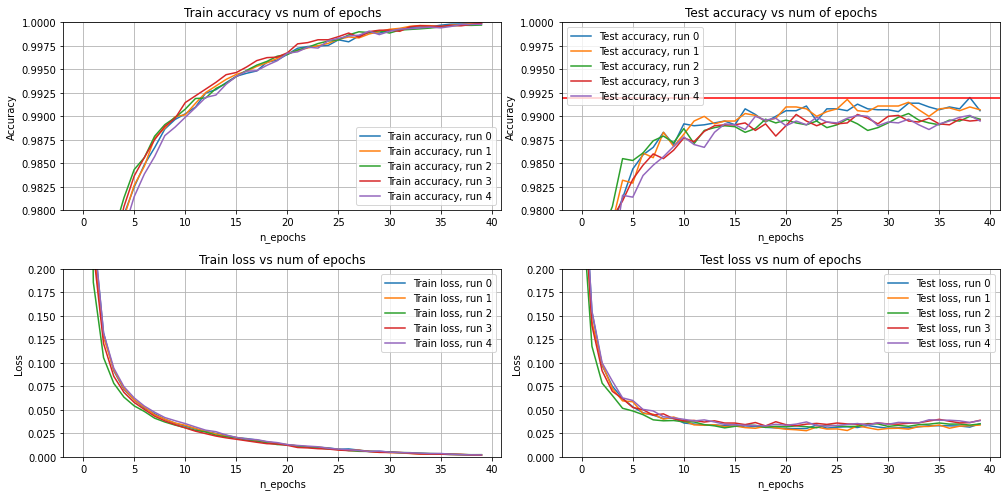

In [ ]:
def plot_loss_and_accuracy_histories(test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories):
    fig, ax = plt.subplots(2, 2, figsize=(14, 7))

    for i in range(5):
        ax[0][0].plot(train_accuracy_histories[i], label=f'Train accuracy, run {i}')
    ax[0][0].set_ylim(bottom=0.98, top=1)
    ax[0][0].grid(True)
    ax[0][0].legend(loc='best')
    ax[0][0].set_xlabel('n_epochs')
    ax[0][0].set_ylabel('Accuracy')
    ax[0][0].set_title('Train accuracy vs num of epochs')

    for i in range(5):
        ax[0][1].plot(test_accuracy_histories[i], label=f'Test accuracy, run {i}')
    ax[0][1].set_ylim(bottom=0.98, top=1)
    ax[0][1].axhline(0.992, c='r')
    ax[0][1].grid(True)
    ax[0][1].legend(loc='best')
    ax[0][1].set_xlabel('n_epochs')
    ax[0][1].set_ylabel('Accuracy')
    ax[0][1].set_title('Test accuracy vs num of epochs')

    for i in range(5):
        ax[1][0].plot(train_loss_histories[i], label=f'Train loss, run {i}')
    ax[1][0].set_ylim(bottom=0, top=0.2)
    ax[1][0].grid(True)
    ax[1][0].legend(loc='best')
    ax[1][0].set_xlabel('n_epochs')
    ax[1][0].set_ylabel('Loss')
    ax[1][0].set_title('Train loss vs num of epochs')

    for i in range(5):
        ax[1][1].plot(test_loss_histories[i], label=f'Test loss, run {i}')
    ax[1][1].set_ylim(bottom=0, top=0.2)
    ax[1][1].grid(True)
    ax[1][1].legend(loc='best')
    ax[1][1].set_xlabel('n_epochs')
    ax[1][1].set_ylabel('Loss')
    ax[1][1].set_title('Test loss vs num of epochs')

    plt.tight_layout();

plot_loss_and_accuracy_histories(test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories)

We see that the original LeNet doesn't achieve the desired quality on validation.

*Do you get overfitting as you increase the number of epochs?*

Well, we see that the quality on validation starts stagnating around epoch 20, and the train quality improves all the way until the final epoch. So we don't get over overfitting per se (as the quality on validation doesn't deteriorate), but still, after a certain moment our network just starts to remember the train set. It's not that surprising, because the dataset is relatively small and the network's size is comparable with it.



*Analyze the variance of the target metric from run to run. How many launches do you need to make before claiming that one architecture is better than another?*

Let's take a look at the standard deviation of accuracy and loss among 5 runs:

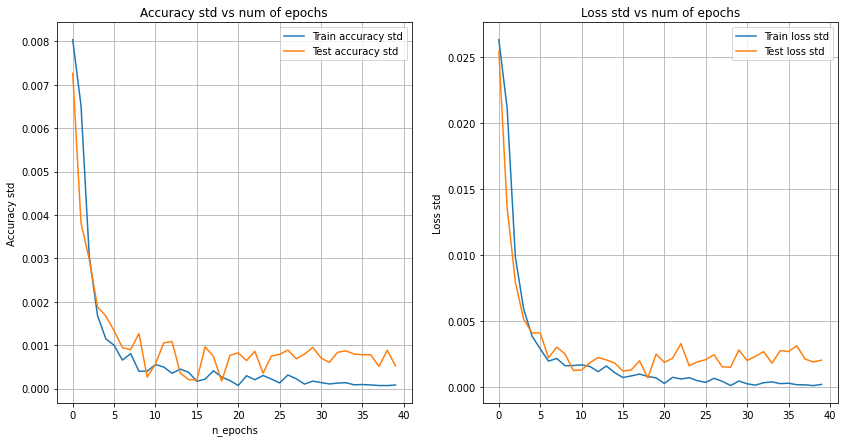

In [ ]:
test_loss_history_std = test_loss_histories.std(axis=0)
test_accuracy_history_std = test_accuracy_histories.std(axis=0)
train_loss_history_std = train_loss_histories.std(axis=0)
train_accuracy_history_std = train_accuracy_histories.std(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(train_accuracy_history_std, label='Train accuracy std')
ax[0].plot(test_accuracy_history_std, label='Test accuracy std')
ax[0].grid(True)
ax[0].legend(loc='best')
ax[0].set_xlabel('n_epochs')
ax[0].set_ylabel('Accuracy std')
ax[0].set_title('Accuracy std vs num of epochs')

ax[1].plot(train_loss_history_std, label='Train loss std')
ax[1].plot(test_loss_history_std, label='Test loss std')
ax[1].grid(True)
ax[1].legend(loc='best')
ax[0].set_xlabel('n_epochs')
ax[1].set_ylabel('Loss std')
ax[1].set_title('Loss std vs num of epochs');

We can conclude that after epoch 10 the variance in quality between runs is negligible.

The accuracy plots above suggest that the original network overfits/starts learning in a meaningful way rather fast. We attack this problem from two angles:
1. First, we try to simplify learning and combat overfitting by neural networks-specific methods:
- We change activations to $\operatorname{ReLU}$'s so that the gradients don't vanish (we also tried to change the average pooling to the maximal in accordance with today's trends, but that didn't take any effect);
- In order to combat overfitting, we reduce the number of parameters in our network. Particularly, we substitute 5x5 convolutions with two subsequent 3x3 convolutions and try to remove the fully connected layers that occupy most of the network's space;
- We introduce batch normalization layers.

2. We construct ensembles of networks to reduce overfitting (since our quality tests are conducted by taking various initializations of the networks with different random seeds, the ensemble comes for free).

## 1. A single modified LeNet

We modified the LeNet's architecture, making the changes in the point 1 above (apart from removing the fully connected layers for now).

Note that  batch normalization was added before activation in convolution layers, and after activation in the fully connected layers (this may seem inconsistent, but leads to better results).

In [ ]:
def make_lenet_mod1(activation=torch.nn.ReLU(),
               pooling=torch.nn.AvgPool2d(kernel_size=2, stride=2)
               ):
    lenet_module_list_mod1 =  [ 
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
            activation,
            torch.nn.BatchNorm2d(num_features=3),
            torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
            activation,
            torch.nn.BatchNorm2d(num_features=6),
            pooling,
            torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=0),
            activation,
            torch.nn.BatchNorm2d(num_features=6),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0),
            activation,
            torch.nn.BatchNorm2d(num_features=16),
            pooling,
            torch.nn.Flatten(),
            torch.nn.Linear(5 * 5 * 16, 120),
            torch.nn.BatchNorm1d(num_features=120),
            activation,
            torch.nn.Linear(120, 84),
            torch.nn.BatchNorm1d(num_features=84),
            activation,
            torch.nn.Linear(84, 10)
        ]
    return torch.nn.Sequential(*lenet_module_list_mod1)


The new network has slightly less parameters:

In [ ]:
lenet_mod1 = make_lenet_mod1()
print(f'Modified LeNet has {sum(np.array(param.size()).prod() for param in lenet_mod1.parameters())} parameters')

Modified LeNet has 61012 parameters


Let's train 5 nets with this architecture and measure their quality:

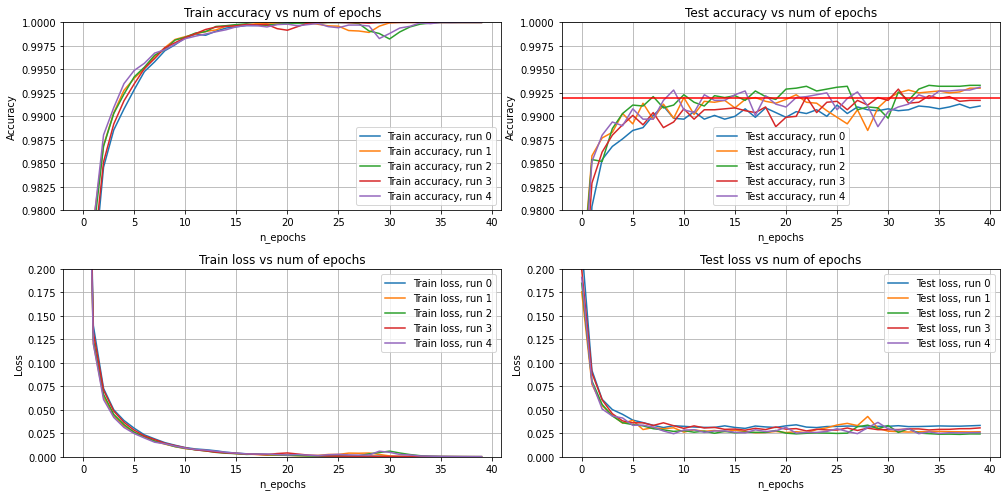

In [ ]:
train_params = dict(
    n_epochs=40,
    batch_size=1024,
    optimizer_params={'lr': 1e-3}
)

test_preds, test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories = \
    run_n_experiments(make_lenet_mod1, n_experiments=5, train_params=train_params)

plot_loss_and_accuracy_histories(test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories)

We see that now our network learns in fewer epochs (perhaps due to the change of the activation function and the introduction of batch normalization). However, one can check that the epochs themselves now take longer (probably due to the introduction of batch normalization).

The average max accuracy among 5 runs is:

In [ ]:
test_accuracy_histories.max(axis=1).mean()

0.99271995

So our architecture does the job.

Now we make an ensemble prediction by simply averaging the individual networks' predictions and measure its accuracy:

In [ ]:
test_preds_ensemble = test_preds.mean(axis=0)
test_ensemble_accuracy = (test_preds_ensemble.argmax(axis=1) == y_test.cpu().numpy()).mean()
test_ensemble_accuracy

0.9947

Ok, so we see that an ensemble of networks gives way better quality than any individual network (which confirms that we may have overfitting).


Can we simplify the architecture even further and achieve the same quality by making an ensemble?

## 2. An ensemble of simple CNNs

Let's remove the fully connected layers from the network:

In [ ]:
def make_lenet_mod2(activation=torch.nn.ReLU(),
               pooling=torch.nn.AvgPool2d(kernel_size=2, stride=2)
               ):
    lenet_module_list_mod2 =  [
        torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
        activation,
        torch.nn.BatchNorm2d(num_features=3),
        torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
        activation,
        torch.nn.BatchNorm2d(num_features=6),
        pooling,
        torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=0),
        activation,
        torch.nn.BatchNorm2d(num_features=6),
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0),
        activation,
        torch.nn.BatchNorm2d(num_features=16),
        pooling,
        torch.nn.Flatten(),
        torch.nn.Linear(5 * 5 * 16, 10),
    ]

    return torch.nn.Sequential(*lenet_module_list_mod2)

The resulting network is 10 times smaller than the original LeNet:

In [ ]:
lenet_mod2 = make_lenet_mod2()
print(f'Modified LeNet has {sum(np.array(param.size()).prod() for param in lenet_mod2.parameters())} parameters')

Modified LeNet has 5480 parameters


Let's train 5 instances of the net:

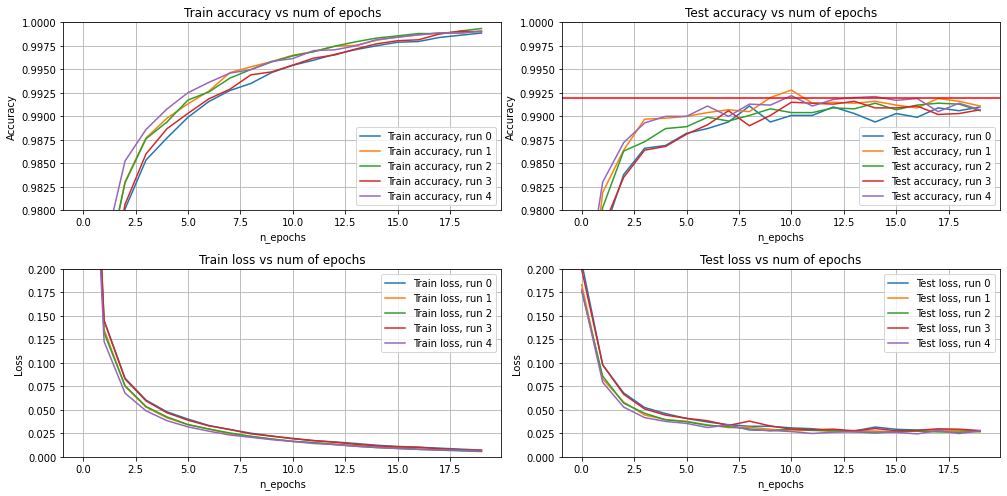

In [ ]:
train_params = dict(
    n_epochs=20,
    batch_size=1024,
    optimizer_params={'lr': 1e-3}
)

test_preds, test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories = \
    run_n_experiments(make_lenet_mod1, n_experiments=5, train_params=train_params)

plot_loss_and_accuracy_histories(test_loss_histories, test_accuracy_histories, train_loss_histories, train_accuracy_histories)

We see that the individual nets achieve around the same quality as the original LeNet, and do it in less epochs.
The ensemble quality is nearly the same as the quality of an ensemble of more complex networks:

In [ ]:
test_preds_ensemble = test_preds.mean(axis=0)
test_ensemble_accuracy = (test_preds_ensemble.argmax(axis=1) == y_test.cpu().numpy()).mean()
test_ensemble_accuracy

0.9943

Simple datasets require simple solutions, apparently.

## Conclusion

It isn't always obvious if it's the bias or the variance factor that contributes more to the current model error.

In order to check if it's bias, consider making your model more complex (ease learning by changing activaion functions, add layers, increase the number of epochs...) and see if the quality of the model increases.

On the other hand, to check if it's variance, check if the quality depends significantly on the initial initialization; simplify the model and/or make it more stable (reduce the number of parameters, add normalizations and dropouts, consider making an ensemble of simple models).



## Some things to try:

Some people at Stepik [managed](https://stepik.org/lesson/209091/step/15?discussion=3592850&unit=182640) to obtain the desired quality by changing the optimizer mid-training. This looks like magic, but perhaps looking into optimizer planners is worth it.